false
-0.6931471805599453
-1.6585896837723293
0.4999832372478349


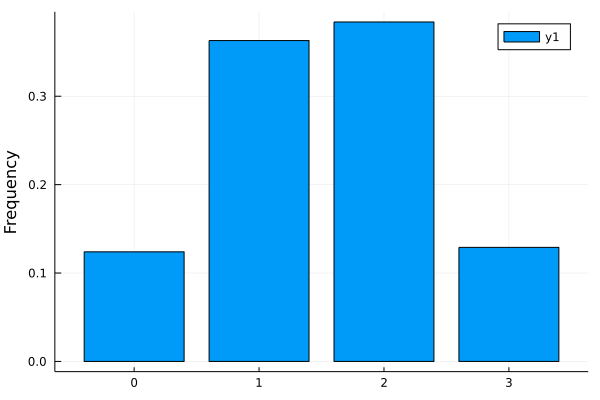

In [18]:
using Gen
include("auxilery.jl")
@gen function model()
    a=@trace(bernoulli(0.5),:a)
    b=@trace(bernoulli(0.5),:b)
    c=@trace(bernoulli(0.5),:c)
    d=a+b+c    
end
ys=[model() for _ in 1:1000]
viz(ys)